In [1]:
from collections import Counter
import numpy as np
import time

import pandas as pd
import datetime as dt

import json
from PIL import Image
import urllib.request
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick
import matplotlib
import cmocean as cmo

import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = str(dt.datetime.now())[:10]

# Premier League

In [3]:
team_abbr = {'Arsenal': 'Arsenal',
             'Aston Villa': 'Aston Villa',
             'AFC Bournemouth': 'Bournemouth',
             'Brighton & Hove Albion': 'Brighton',
             'Burnley': 'Burnley',
             'Chelsea': 'Chelsea',
             'Crystal Palace FC': 'Crystal Palace',
             'Everton FC': 'Everton',
             'Leicester City': 'Leicester',
             'Liverpool': 'Liverpool',
             'Manchester City': 'Man City',
             'Manchester United': 'Man Utd',
             'Newcastle United FC': 'Newcastle',
             'Norwhich City': 'Norwich',
             'Sheffield United': 'Sheffield Utd',
             'Southampton FC': 'Southampton',
             'Tottenham Hotspur': 'Spurs',
             'Watford FC': 'Watford',
             'West Ham United': 'West Ham',
             'Wolverhampton': 'Wolves',
             'Cardiff City': 'Cardiff',
             'Fulham': 'Fulham',
             'Huddersfield Town': 'Huddersfield',
             'Leeds United': 'Leeds',
             'Stoke City FC': 'Stoke',
             'Swansea City FC': 'Swansea',
             'West Bromwich Albion': 'West Brom'}

team_wiki = {'Arsenal': 'https://en.wikipedia.org/wiki/Arsenal_F.C.',
             'Aston Villa': 'https://en.wikipedia.org/wiki/Aston_Villa_F.C.',
             'Brighton & Hove Albion': 'https://en.wikipedia.org/wiki/Brighton_%26_Hove_Albion_F.C.',
             'Burnley': 'https://en.wikipedia.org/wiki/Burnley_F.C.',
             'Chelsea': 'https://en.wikipedia.org/wiki/Chelsea_F.C.',
             'Crystal Palace FC': 'https://en.wikipedia.org/wiki/Crystal_Palace_F.C.',
             'Everton FC': 'https://en.wikipedia.org/wiki/Everton_F.C.',
             'Fulham': 'https://en.wikipedia.org/wiki/Fulham_F.C.',
             'Leeds United': 'https://en.wikipedia.org/wiki/Leeds_United_F.C.',
             'Leicester City': 'https://en.wikipedia.org/wiki/Leicester_City_F.C.',
             'Liverpool': 'https://en.wikipedia.org/wiki/Liverpool_F.C.',
             'Manchester City': 'https://en.wikipedia.org/wiki/Manchester_City_F.C.',
             'Manchester United': 'https://en.wikipedia.org/wiki/Manchester_United_F.C.',
             'Newcastle United FC': 'https://en.wikipedia.org/wiki/Newcastle_United_F.C.',
             'Sheffield United': 'https://en.wikipedia.org/wiki/Sheffield_United_F.C.',
             'Southampton FC': 'https://en.wikipedia.org/wiki/Southampton_F.C.',
             'Tottenham Hotspur': 'https://en.wikipedia.org/wiki/Tottenham_Hotspur_F.C.',
             'West Bromwich Albion': 'https://en.wikipedia.org/wiki/West_Bromwich_Albion_F.C.',
             'West Ham United': 'https://en.wikipedia.org/wiki/West_Ham_United_F.C.',
             'Wolverhampton': 'https://en.wikipedia.org/wiki/Wolverhampton_Wanderers_F.C.'}

In [4]:
team_imgs = {}
for team, turl in team_wiki.items():
    page = requests.get(turl)
    soup = BeautifulSoup(page.content, 'html.parser')
    urlx = 'https:'+soup.find_all('table',{'class':'infobox vcard'})[0].find_all('img')[0]['src']
    with urllib.request.urlopen(urlx) as url:
        with open('temp.png', 'wb') as f:
            f.write(url.read())

    img = Image.open('temp.png')
    img = np.array(img)
    team_imgs[team_abbr[team]] = img    

In [5]:
url = 'https://teamcolorcodes.com/soccer/premier-league-color-codes/'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
team_urls = {i.text:i['href'] for i in soup.find_all('a',{'class':'team-button'})}
team_cols = {}

for team, turl in team_urls.items():
    page = requests.get(turl)
    soup = BeautifulSoup(page.content, 'html.parser')
    col_list = [i for i in soup.find_all('div',{'class':'colorblock'})
                if len(i['class']) == 1 and i['class'][0]=='colorblock']
    col_list = [i['style'].split('background-color: ')[1][:7] for i in col_list]
    col_list = [i for i in col_list if i.lower() != '#ffffff']
    if len(col_list)<2:
        col_list.append('.5')

    if len(col_list)<3:
        col_list.append('.2')

    team_cols[team_abbr[team]] = col_list

In [6]:
ngames = 38
nteams = 20

ppw = 3
ppd = 1
ppl = 0

niter = 2000

In [7]:
soc_df = pd.read_html('https://fixturedownload.com/results/epl-2020')[0]
soc_df.columns = ['round','date','location','home','away','result']
soc_df['date'] = pd.to_datetime(soc_df['date']).astype(str).str[:11]
rem_df = soc_df.loc[soc_df['result']=='-'].copy()
soc_df = soc_df.loc[soc_df['result']!='-'].copy()
soc_df['home_goals'] = soc_df['result'].str.split(' - ').str[0].astype(int)
soc_df['away_goals'] = soc_df['result'].str.split(' - ').str[1].astype(int)
soc_df['home_points'] = ppl
soc_df['away_points'] = ppl

for row in range(soc_df.shape[0]):
    if soc_df.iloc[row,:]['home_goals']==soc_df.iloc[row,:]['away_goals']:
        soc_df.iloc[row,-2] = ppd
        soc_df.iloc[row,-1] = ppd
    elif soc_df.iloc[row,:]['home_goals']>soc_df.iloc[row,:]['away_goals']:
        soc_df.iloc[row,-2] = ppw
    else:
        soc_df.iloc[row,-1] = ppw

In [8]:
teams_out = []
for team_st in soc_df['home'].unique():
    dfi = soc_df.loc[(soc_df['home']==team_st)|(soc_df['away']==team_st)].copy()
    deets_i = ['home' if i==team_st else 'away' for i in dfi['home'].values]
    team_points = [dfi['home_points'].values[ix] if i=='home' else dfi['away_points'].values[ix]
                   for ix, i in enumerate(deets_i)]
    team_goals_for = [dfi['home_goals'].values[ix] if i=='home' else dfi['away_goals'].values[ix]
                      for ix, i in enumerate(deets_i)]
    team_goals_against = [dfi['away_goals'].values[ix] if i=='home' else dfi['home_goals'].values[ix]
                          for ix, i in enumerate(deets_i)]

    dfout_i = pd.DataFrame({'round':list(range(1,len(deets_i)+1)),'team':[team_st]*len(deets_i), 
                            'points':team_points,
                            'goals_for':team_goals_for,
                            'goals_against':team_goals_against})

    dfout_i['cumulative_goals_for'] = np.cumsum(dfout_i['goals_for'])
    dfout_i['cumulative_goals_against'] = np.cumsum(dfout_i['goals_against'])
    dfout_i['cumulative_points'] = np.cumsum(dfout_i['points'])
    teams_out.append(dfout_i)

In [9]:
season_df = pd.concat(teams_out).reset_index().iloc[:,1:]
current_df = season_df.groupby('team').agg({'round':'max',
                                            'cumulative_points':'max',
                                            'cumulative_goals_for':'max',
                                            'cumulative_goals_against':'max'}).reset_index()

current_df['cumulative_goal_diff'] = current_df['cumulative_goals_for']-\
                                     current_df['cumulative_goals_against']
current_df = current_df.sort_values(['cumulative_points',
                                     'cumulative_goal_diff',
                                     'cumulative_goals_for',
                                     'cumulative_goals_against'],ascending=False).reset_index().iloc[:,1:]
current_df['rank'] = list(range(1,nteams+1))

In [10]:
poss_out_df = []
for ti, team_st in enumerate(current_df['team'].values):
    print(dt.datetime.now(),team_st)
    dfi = current_df.loc[current_df['team']==team_st].copy()
    games_left = ngames - dfi['round'].values[0]
    rem_dfi = rem_df.loc[(rem_df['home']==team_st)|(rem_df['away']==team_st)].copy()
    opponents_i = [i if i != team_st else rem_dfi['away'].values[ix]
                   for ix, i in enumerate(rem_dfi['home'].values)]

    possible_outcomes = list(it.product([ppl,ppd,ppw],repeat=games_left))

    mean_goals_for = season_df.loc[season_df['team']==team_st]['goals_for'].mean()
    stdv_goals_for = season_df.loc[season_df['team']==team_st]['goals_for'].std()

    outcomes_counter = {i:0 for i in possible_outcomes}
    outcomes_counter_goals = {i:{'for':[],'against':[],'diff':[]} for i in possible_outcomes}
    goals_for_list = []
    goals_against_list = []
    for _ in range(niter):

        sim_goals_for = np.random.normal(mean_goals_for,stdv_goals_for,size=games_left).round()
        sim_goals_for[sim_goals_for<1] = 0

        sim_goals_against = []
        for gl in range(games_left):
            mga = season_df.loc[season_df['team']==opponents_i[gl]]['goals_for'].mean()
            sga = season_df.loc[season_df['team']==opponents_i[gl]]['goals_for'].std()
            sim_goal_ag = np.round(np.random.normal(mga,sga))
            if sim_goal_ag < 1:
                sim_goal_ag = 0
            sim_goals_against.append(sim_goal_ag)

        sim_fixtures = list(zip(sim_goals_for,sim_goals_against))

        sim_points = []
        for game in sim_fixtures:
            if game[0]>game[1]:
                sim_points.append(ppw)
            if game[0]==game[1]:
                sim_points.append(ppd)
            if game[0]<game[1]:
                sim_points.append(ppl)

        outcomes_counter[tuple(sim_points)] += 1
        cum_g_f_i = (dfi['cumulative_goals_for'] + sum([i[0] for i in sim_fixtures])).mean()
        cum_g_a_i = (dfi['cumulative_goals_against'] + sum([i[1] for i in sim_fixtures])).mean()
        cum_g_d_i = cum_g_f_i-cum_g_a_i
        outcomes_counter_goals[tuple(sim_points)]['for'].append(cum_g_f_i)
        outcomes_counter_goals[tuple(sim_points)]['against'].append(cum_g_a_i)
        outcomes_counter_goals[tuple(sim_points)]['diff'].append(cum_g_d_i)

    poss_points = {x:0 for x in np.unique([sum(i) for i in outcomes_counter.keys()])}
    for f,v in outcomes_counter.items():
        poss_points[sum(f)] += v/niter

    poss_goals_f = {x:[] for x in np.unique([sum(i) for i in outcomes_counter_goals.keys()])}
    poss_goals_a = {x:[] for x in np.unique([sum(i) for i in outcomes_counter_goals.keys()])}
    poss_goals_d = {x:[] for x in np.unique([sum(i) for i in outcomes_counter_goals.keys()])}
    for f,v in outcomes_counter_goals.items():
        poss_goals_f[sum(f)] += v['for']
        poss_goals_a[sum(f)] += v['against']
        poss_goals_d[sum(f)] += v['diff']

    poss_goals_f_s = {i:np.std(j) if j != [] else np.nan for i,j in poss_goals_f.items()}
    poss_goals_a_s = {i:np.std(j) if j != [] else np.nan for i,j in poss_goals_a.items()}
    poss_goals_d_s = {i:np.std(j) if j != [] else np.nan for i,j in poss_goals_d.items()}
    poss_goals_f = {i:np.mean(j) if j != [] else np.nan for i,j in poss_goals_f.items()}
    poss_goals_a = {i:np.mean(j) if j != [] else np.nan for i,j in poss_goals_a.items()}
    poss_goals_d = {i:np.mean(j) if j != [] else np.nan for i,j in poss_goals_d.items()}

    minpoints = current_df['cumulative_points'].min()
    maxpoints = current_df['cumulative_points'].max() + (ngames-current_df['round'].min())*3

    all_possible_points = list(range(minpoints-1,maxpoints+2))
    team_possible_points = {i:0 for i in all_possible_points}
    team_possible_goals_f = {i:0 for i in all_possible_points}
    team_possible_goals_a = {i:0 for i in all_possible_points}
    team_possible_goals_d = {i:0 for i in all_possible_points}
    team_possible_goals_f_s = {i:0 for i in all_possible_points}
    team_possible_goals_a_s = {i:0 for i in all_possible_points}
    team_possible_goals_d_s = {i:0 for i in all_possible_points}
    for i,j in poss_points.items():
        team_possible_points[(i+dfi['cumulative_points'].mean())] += j
        team_possible_goals_f[(i+dfi['cumulative_points'].mean())] += poss_goals_f[i]
        team_possible_goals_a[(i+dfi['cumulative_points'].mean())] += poss_goals_a[i]
        team_possible_goals_d[(i+dfi['cumulative_points'].mean())] += poss_goals_d[i]
        team_possible_goals_f_s[(i+dfi['cumulative_points'].mean())] += poss_goals_f_s[i]
        team_possible_goals_a_s[(i+dfi['cumulative_points'].mean())] += poss_goals_a_s[i]
        team_possible_goals_d_s[(i+dfi['cumulative_points'].mean())] += poss_goals_d_s[i]

    poss_dfi = pd.DataFrame({"team":[team_st]*len(all_possible_points),
                 'possible_points':list(team_possible_points.keys()),
                 'probability':list(team_possible_points.values()),
                 'mean_goals_for':list(team_possible_goals_f.values()),
                 'mean_goals_against':list(team_possible_goals_a.values()),
                 'mean_goals_diff':list(team_possible_goals_d.values()),
                 'stdv_goals_for':list(team_possible_goals_f_s.values()),
                 'stdv_goals_against':list(team_possible_goals_a_s.values()),
                 'stdv_goals_diff':list(team_possible_goals_d_s.values())})
    poss_dfi = poss_dfi.loc[poss_dfi['probability']>0].copy()

    poss_out_df.append(poss_dfi)

2021-05-11 11:08:04.242599 Man City
2021-05-11 11:08:09.886442 Man Utd
2021-05-11 11:08:17.504926 Chelsea
2021-05-11 11:08:23.278360 Leicester
2021-05-11 11:08:28.928237 West Ham
2021-05-11 11:08:34.962425 Liverpool
2021-05-11 11:08:42.392590 Spurs
2021-05-11 11:08:48.189389 Everton
2021-05-11 11:08:55.432170 Arsenal
2021-05-11 11:09:01.149079 Leeds
2021-05-11 11:09:06.721380 Aston Villa
2021-05-11 11:09:13.489686 Wolves
2021-05-11 11:09:18.732122 Crystal Palace
2021-05-11 11:09:25.695557 Burnley
2021-05-11 11:09:31.238490 Newcastle
2021-05-11 11:09:36.616702 Brighton
2021-05-11 11:09:42.035204 Southampton
2021-05-11 11:09:49.266047 Fulham
2021-05-11 11:09:54.582715 West Brom
2021-05-11 11:10:00.100296 Sheffield Utd


In [11]:
prob_df = pd.concat(poss_out_df).reset_index().iloc[:,1:]

In [12]:
rank_out = []
for sim_num in range(niter):
    tmp_dict = {'team':[],'sim_points':[],'sim_goals_for':[],
                'sim_goals_against':[],'sim_goals_diff':[]}

    for ti, team_st in enumerate(current_df['team'].values):
        pfi = prob_df.loc[prob_df['team']==team_st].copy()
        tmp_dict['team'].append(team_st)
        sim_points = np.random.choice(pfi['possible_points'].values, p=pfi['probability'].values)
        tmp_dict['sim_points'].append(sim_points)
        mgf_sim = pfi.loc[pfi['possible_points']==sim_points]['mean_goals_for'].mean()
        mga_sim = pfi.loc[pfi['possible_points']==sim_points]['mean_goals_against'].mean()
        sgf_sim = pfi.loc[pfi['possible_points']==sim_points]['stdv_goals_for'].mean()
        sga_sim = pfi.loc[pfi['possible_points']==sim_points]['stdv_goals_against'].mean()

        sim_for = np.round(np.random.normal(mgf_sim,sgf_sim))
        sim_agn = np.round(np.random.normal(mga_sim,sga_sim))
        sim_dif = sim_for-sim_agn

        tmp_dict['sim_goals_for'].append(sim_for)
        tmp_dict['sim_goals_against'].append(sim_agn)
        tmp_dict['sim_goals_diff'].append(sim_dif)

    df_tmp = pd.DataFrame(tmp_dict)
    df_tmp = df_tmp.sort_values(['sim_points','sim_goals_diff','sim_goals_for',
                                 'sim_goals_against'],ascending=False).reset_index().iloc[:,1:]

    df_tmp['rank'] = list(range(1,nteams+1))
    df_tmp['sim_num'] = sim_num
    df_tmp = df_tmp[['team','rank','sim_num']].copy()
    rank_out.append(df_tmp)

In [13]:
rank_df = pd.concat(rank_out)

In [14]:
team_imgs.keys()

dict_keys(['Arsenal', 'Aston Villa', 'Brighton', 'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Leeds', 'Leicester', 'Liverpool', 'Man City', 'Man Utd', 'Newcastle', 'Sheffield Utd', 'Southampton', 'Spurs', 'West Brom', 'West Ham', 'Wolves'])

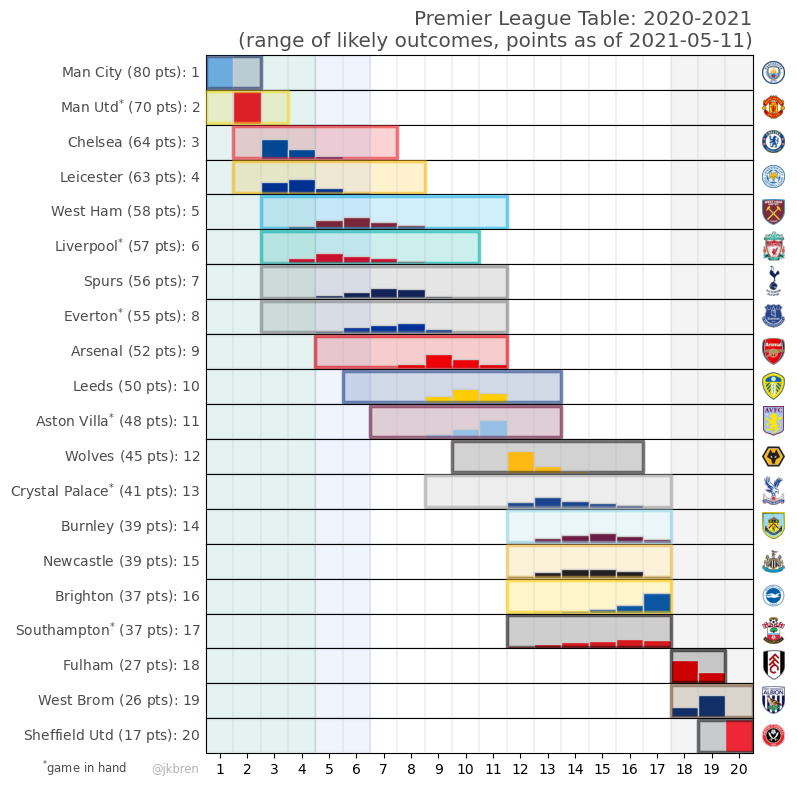

In [21]:
fig, ax = plt.subplots(nteams, 2, figsize=(7.5,9.25), dpi=100, gridspec_kw={'width_ratios':[20,1]})
plt.subplots_adjust(hspace=0,wspace=0.025)

for ti, team_st in enumerate(current_df['team'].values):
    dfi = rank_df.loc[rank_df['team']==team_st].copy()
    plot_dict = {i:0 for i in range(1,21)}
    for i,j in dict(Counter(dfi['rank'].values)).items():
        plot_dict[i] += j/niter
    xvals = [i for i,j in plot_dict.items() if j>0]
    yvals = [j for i,j in plot_dict.items() if j>0]

    col = team_cols[team_st][0]
    col2 = team_cols[team_st][1]
    ax[(ti,0)].bar(xvals, yvals, width=1, fc=col, ec='.8', lw=1,zorder=2)
    ax[(ti,0)].vlines(np.linspace(0.5, nteams-0.5, nteams), 0, 1, color='.7', lw=0.25)
    ax[(ti,0)].fill_between([min(xvals)-0.5, max(xvals)+0.5], 0.025, 0.975,
                            alpha=0.2, lw=2.5, fc=col2, ec=col2, zorder=1)
    ax[(ti,0)].fill_between([min(xvals)-0.5, max(xvals)+0.5], 0.025, 0.975,
                            alpha=0.5, lw=2.5, fc='none', ec=col2, zorder=3)
#     ax[(ti,0)].fill_between([ti+0.5,ti+1.5], 0, 1, alpha=0.6, lw=2, color=col2, zorder=1)

    ax[(ti,0)].fill_between([-0.5,4.5], 0, 1, alpha=0.1, color='teal', zorder=1)
    ax[(ti,0)].fill_between([4.5,6.5], 0, 1, alpha=0.1, color='cornflowerblue', zorder=1)
    ax[(ti,0)].fill_between([nteams-2.5,nteams+1.5], 0, 1, alpha=0.1, color='.6', zorder=1)

    ax[(ti,0)].set_yticks([])
    if ti==nteams-1:
        ax[(ti,0)].set_xticks(range(1,nteams+1))
    else:
        ax[(ti,0)].set_xticks([])

    ax[(ti,0)].set_ylim(-0.025, 1.025)
    ax[(ti,0)].set_xlim(0.5, nteams+0.5)
    curr_pts = int(current_df.loc[current_df['team']==team_st]['cumulative_points'].mean())
    curr_rnd = int(current_df.loc[current_df['team']==team_st]['round'].mean())
    gih = ''
    if current_df['round'].max() > curr_rnd:
        gih = '*'

    ax[(ti,0)].set_ylabel(team_st+r"$^{%s}$"%(gih)+" (%i pts)"%(curr_pts)+": %i"%(ti+1),
                          rotation=0, ha='right', va='center', color='.3')

    ax[(ti,1)].imshow(team_imgs[team_st])
    xshape_st = team_imgs[team_st].shape[1]
    yshape_st = team_imgs[team_st].shape[0]
    ax[(ti,1)].set_xlim(-xshape_st*0.1,xshape_st*0.1+xshape_st)
    ax[(ti,1)].set_ylim(yshape_st*0.1+yshape_st,-yshape_st*0.1)
    ax[(ti,1)].set_axis_off()


ax[(0,0)].set_title('Premier League Table: 2020-2021\n(range of likely outcomes, points as of %s)'%today,
                    fontsize='x-large', color='.3', ha='right', x=1)
ax[(nteams-1,0)].text(-1.5, -0.6, '@jkbren', fontsize='small', color='.7')
ax[(nteams-1,0)].text(-5.5, -0.6,r"$^{*}$"+'game in hand', fontsize='small', color='.3')

plt.savefig('../figs/pngs/premier_league_prob_table.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/premier_league_prob_table.pdf',bbox_inches='tight')

plt.show()

In [16]:
# fig, ax = plt.subplots(20, 1, figsize=(4,7), dpi=100)

# for ti, team_st in enumerate(current_df['team'].values):
#     dfi = current_df.loc[current_df['team']==team_st].copy()
#     ax[ti].bar(prob_df.loc[prob_df['team']==team_st]['possible_points'].values,
#                prob_df.loc[prob_df['team']==team_st]['probability'].values, width=1)

# #     ax[ti].bar(dfi['rank'].values, height=[1], width=1)
#     ax[ti].vlines(dfi['cumulative_points'].mean(), 0, 1, color='.4')
#     ax[ti].set_yticks([])
#     ax[ti].set_xlim(all_possible_points[-1],all_possible_points[0])
#     ax[ti].set_ylim(0, 0.3)
    
# #     ax[ti].set_ylim(0,1)
# #     ax[ti].set_xlim(0.5,20.5)
#     if ti==19:
#         ax[ti].set_xticks(np.linspace(90, 20, 8))
#     else:
#         ax[ti].set_xticks([])

# plt.show()